In [6]:
import pandas as pd
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
from pathlib import Path
import json
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from datetime import datetime
import re
from scipy import stats
import numpy as np
import statsmodels.api as sm
import statsmodels
from matplotlib import colormaps
from tqdm.notebook import tqdm
import helpers
from collections import defaultdict
from tqdm.notebook import tqdm


from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.regression.linear_model import OLS

from mri_data import file_manager as fm

## Load Data

In [ ]:
drive_root = fm.get_drive_root()
dataroot = drive_root / "3Tpioneer_bids"
data_dir = Path("/home/srs-9/Projects/ms_mri/data")
fig_path = Path("/home/srs-9/Projects/ms_mri/analysis/thalamus/figures_tables/edss_regressions")

choroid_volumes = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/choroid_aschoplex_volumes.csv", index_col="subid"
).dropna()
ventricle_volumes = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/analysis/paper1/data0/ventricle_volumes.csv",
    index_col="subid",
)
tiv = pd.read_csv("/home/srs-9/Projects/ms_mri/data/tiv_data.csv", index_col="subid")

df = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/clinical_data_processed.csv", index_col="subid"
)



In [ ]:
sdmt = pd.read_csv("/home/srs-9/Projects/ms_mri/analysis/thalamus/SDMT_sheet.csv", index_col="subid")
df = df.join([choroid_volumes, ventricle_volumes, tiv, sdmt['SDMT']])
df['SDMT'] = pd.to_numeric(df['SDMT'], errors='coerce')
df['thalamus_sqrt'] = np.sqrt(df['thalamus'])
df['thalamus_curt'] = np.sqrt(df['thalamus']**3)
ventricle_volumes = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/analysis/paper1/data0/ventricle_volumes.csv",
    index_col="subid",
)
csf_volumes = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/analysis/thalamus/data0/csf_volumes.csv",
    index_col="subid",
)
third_ventricle_width = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/analysis/thalamus/data0/third_ventricle_width.csv",
    index_col="subid",
)
df["periCSF"] = csf_volumes["peripheral"]
df["allCSF"] = csf_volumes["all"]
df["thirdV"] = csf_volumes["third_ventricle"]
df_z = df.copy()
numeric_cols = df.select_dtypes(include='number').columns
df_z[numeric_cols] = df_z[numeric_cols].apply(stats.zscore, nan_policy="omit")



df_ms = df[df['dz_type2'] == "MS"]
df_ms_z = df_ms.copy()
df_ms_z[numeric_cols] = df_ms_z[numeric_cols].apply(stats.zscore, nan_policy="omit")

# assert df.loc[1340, 'EDSS'] == 2.5


viridis = colormaps['viridis'].resampled(20)

colors = helpers.get_colors()

In [13]:
df_thomas = pd.read_csv(data_dir / "hipsthomas_vols.csv", index_col="subid")
cols_orig = df_thomas.columns
new_colnames = {}
for col in df_thomas.columns:
    new_col = re.sub(r"(\d+)-([\w-]+)", r"\2_\1", col)
    new_col = re.sub("-", "_", new_col)
    new_colnames[col] = new_col
df_thomas = df_thomas.rename(columns=new_colnames)
df_thomas_norm = df_thomas.apply(lambda col: col / df_thomas['THALAMUS_1'])
df_thomas_z = df_thomas.apply(stats.zscore, nan_policy="omit")
df_thomas_norm_z = df_thomas_norm.apply(stats.zscore, nan_policy="omit")

df_thomas_left = pd.read_csv(data_dir / "hipsthomas_left_vols.csv", index_col="subid")
df_thomas_left = df_thomas_left.rename(columns=new_colnames)
df_thomas_left_norm = df_thomas_left.apply(lambda col: col / df_thomas['THALAMUS_1'])
df_thomas_left_z = df_thomas_left.apply(stats.zscore, nan_policy="omit")
df_thomas_left_norm_z = df_thomas_left_norm.apply(stats.zscore, nan_policy="omit")


df_thomas_right = pd.read_csv(data_dir / "hipsthomas_right_vols.csv", index_col="subid")
df_thomas_right = df_thomas_right.rename(columns=new_colnames)
df_thomas_right_norm = df_thomas_right.apply(lambda col: col / df_thomas['THALAMUS_1'])
df_thomas_right_z = df_thomas_right.apply(stats.zscore, nan_policy="omit")
df_thomas_right_norm_z = df_thomas_right_norm.apply(stats.zscore, nan_policy="omit")


thalamic_nuclei = [2, 4, 5, 6, 7, 8, 9, 10, 11, 12]
thalamic_nuclei_str = [str(i) for i in thalamic_nuclei]

hips_thomas_ref = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/hipsthomas_struct_index.csv", index_col="index"
)['struct']
# hips_thomas_ref.rename(columns={"struct": "struct_name"}, inplace=True)

choroid_dists = pd.read_csv(data_dir / "centroid-choroid_centroid-left.csv", index_col="subid")
ventricle_dists = pd.read_csv(
    data_dir / "centroid-ventricle_SDT.csv", index_col="subid"
)

mni_choroid_dists = pd.read_csv("/home/srs-9/Projects/ms_mri/data/mni-centroid-choroid_SDT2.csv")

def combine_nuclei(df):
    df2 = pd.DataFrame()
    df2['anterior'] = df['AV_2']
    df2['ventral'] = df['VA_4'] + df['VLa_5'] + df['VLP_6'] + df['VPL_7']
    df2['intralaminar'] = df['CM_11'] 
    df2['medial'] = df['MD_Pf_12']
    df2['posterior'] = df['Pul_8'] + df['LGN_9'] + df['MGN_10']
    df2['THALAMUS_1'] = df['THALAMUS_1']
    return df2

def combine_nuclei2(df):
    df2 = pd.DataFrame()
    df2["anterior"] = df["AV_2"]
    df2["ventral"] = df["VA_4"] + df["VLa_5"] + df["VLP_6"] + df["VPL_7"]
    df2["medial"] = df["MD_Pf_12"] + df["CM_11"]
    df2["posterior"] = df["Pul_8"] + df["LGN_9"] + df["MGN_10"]
    df2["THALAMUS_1"] = df["THALAMUS_1"]
    return df2

df_thomas2 = combine_nuclei2(df_thomas)
grouped_nuclei = df_thomas2.columns[~df_thomas2.columns.isin(["THALAMUS_1"])]
df_thomas2_z = df_thomas2.apply(stats.zscore, nan_policy="omit")
df_thomas2_norm = df_thomas2.apply(lambda col: col / df_thomas['THALAMUS_1'])
df_thomas2_norm_z = df_thomas2_norm.apply(stats.zscore, nan_policy="omit")

df_thomas2_left = combine_nuclei2(df_thomas_left)
df_thomas2_left_z = df_thomas2_left.apply(stats.zscore, nan_policy="omit")
df_thomas2_norm_left = df_thomas2.apply(lambda col: col / df_thomas['THALAMUS_1'])
df_thomas2_norm_left_z = df_thomas2_norm_left.apply(stats.zscore, nan_policy="omit")

df_thomas2_right = combine_nuclei2(df_thomas_right)
df_thomas2_right_z = df_thomas2_right.apply(stats.zscore, nan_policy="omit")
df_thomas2_norm_right = df_thomas2.apply(lambda col: col / df_thomas['THALAMUS_1'])
df_thomas2_norm_right_z = df_thomas2_norm_right.apply(stats.zscore, nan_policy="omit")

/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pandas/core/apply.py:1081: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  results[i] = self.func(v, *self.args, **self.kwargs)
/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pandas/core/apply.py:1081: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  results[i] = self.func(v, *self.args, **self.kwargs)
/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pandas/core/apply.py:1081: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  results[i] = self.func(v, *self.args, **self.kwargs)
/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/p

## Functions

In [14]:
def compute_se_diff(se1, n1, se2, n2):
    return np.sqrt((se1**2/n1) + (se2**2/n2))

def plot_regression(
    data, predictor, outcome, covariates, xlabel=None, ylabel=None, title=None,
    color="blue1"
):
    plus_covariates = ""
    if len(covariates) > 0:
        plus_covariates = f"+ {' + '.join(covariates)}"
    if xlabel is None:
        xlabel = predictor
    if ylabel is None:
        ylabel = outcome
    if title is None:
        title = f"{outcome} vs {predictor}"
    
    light_color = colors[f"light {color}"]
    dark_color = colors[f"dark {color}"]

    formula = f"{outcome} ~ {predictor} {plus_covariates}"
    res = sm.OLS.from_formula(formula, data=data).fit()
    x, y_pred, y_lims = helpers.get_regression_y(data, res, predictor, outcome)

    fig, axs = plt.subplot_mosaic(
        [['histx', '.'], ['scatter', 'histy']],
        figsize=(8, 6),
        width_ratios=(4, 1),
        height_ratios=(1, 4),
        layout='constrained',
    )

    helpers.scatter_hist(
        data[predictor],
        data[outcome],
        axs['scatter'],
        axs['histx'],
        axs['histy'],
        light_color=light_color,
        dark_color=dark_color,
    )

    axs['scatter'].plot(x, y_pred, color="black")
    axs['scatter'].fill_between(
        x, y_lims[0], y_lims[1], alpha=0.4, color=light_color
    )
    axs['scatter'].set_ylabel(ylabel)
    axs['scatter'].set_xlabel(xlabel)
    fig.suptitle(title)
    return fig, axs


def geo_mean(x):
    return np.prod(x)**(1.0/len(x))


def balance(num, denom):
    return np.log(geo_mean(num)/geo_mean(denom))

def log_ratio(num, denom):
    return np.log(num / geo_mean(denom).T)

## Main MRI Features

### Regressions

#### MS Patients

In [5]:
model_data = df_ms_z.copy()
model_data = model_data.join([df_thomas_z])
covariates = "age + Female + tiv"

outcome = "EDSS_sqrt"
predictors = ["brain", "white", "grey", "cortical_thickness", "THALAMUS_1", "t2lv", "PRL", "choroid_volume", "ventricle_volume"]

pvals = {}
coefs = {}
stderrs = {}
llci = {}
ulci = {}
ci_str = {}
r2 = {}

for x in predictors:
    formula = f"{outcome} ~ {x} + {covariates}"
    res = sm.OLS.from_formula(formula, data=model_data).fit()
    pvals[x] = res.pvalues[x]
    coefs[x] = res.params[x]
    stderrs[x] = res.HC0_se[x]
    ci = res.conf_int()
    llci[x] = ci.loc[x, 0]
    ulci[x] = ci.loc[x, 1]
    ci_str[x] = f"[{llci[x]:.6f}, {ulci[x]:.6f}]"
    r2[x] = res.rsquared_adj


regression_results = pd.DataFrame({"coef": coefs, "stderr": stderrs, "llci": llci, "ulci": ulci, "pvals": pvals, "ci": ci_str})
regression_results['p_fdr'] = stats.false_discovery_control(
    regression_results['pvals'], method='bh'
)
regression_results['R2'] = r2
regression_results.index.name = "structure"
# regression_results.to_excel(fig_path / "EDSS_and_main_mri_features_MS.xlsx")
regression_results

,coef,stderr,llci,ulci,pvals,ci,p_fdr,R2
structure,,,,,,,,
brain,-0.081767,0.047614,-0.175980,0.012446,8.876744e-02,"[-0.175980, 0.012446]",1.141296e-01,0.217506
white,-0.033401,0.045745,-0.121893,0.055091,4.586032e-01,"[-0.121893, 0.055091]",4.586032e-01,0.213391
grey,-0.104938,0.050713,-0.203374,-0.006501,3.672554e-02,"[-0.203374, -0.006501]",5.508831e-02,0.220066
cortical_thickness,-0.220291,0.044493,-0.312000,-0.128582,3.147701e-06,"[-0.312000, -0.128582]",1.416465e-05,0.249745
THALAMUS_1,-0.292028,0.045303,-0.384468,-0.199588,1.220738e-09,"[-0.384468, -0.199588]",1.098664e-08,0.274819
t2lv,0.111863,0.047572,0.028841,0.194885,8.383220e-03,"[0.028841, 0.194885]",1.886225e-02,0.224561
PRL,0.106407,0.039786,0.022330,0.190484,1.323684e-02,"[0.022330, 0.190484]",2.382632e-02,0.223152
choroid_volume,0.071059,0.043683,-0.020848,0.162966,1.293490e-01,"[-0.020848, 0.162966]",1.455176e-01,0.216463
ventricle_volume,0.210342,0.044821,0.119831,0.300853,6.400253e-06,"[0.119831, 0.300853]",1.920076e-05,0.247584


In [30]:
resThal = sm.OLS.from_formula("THALAMUS_1 ~ age + Female + tiv", data=model_data).fit()
resCT = sm.OLS.from_formula("cortical_thickness ~ age + Female + tiv", data=model_data).fit()
resEDSS = sm.OLS.from_formula("EDSS_sqrt ~ age + Female + tiv", data=model_data).fit()

resids = pd.concat([resThal.resid.rename("THALAMUS_1"),
                    resCT.resid.rename("cortical_thickness"),
                    resEDSS.resid.rename("EDSS_sqrt")], axis=1).dropna()


rx1y = stats.pearsonr(resids['THALAMUS_1'], resids['EDSS_sqrt']).statistic
rx2y = stats.pearsonr(resids['cortical_thickness'], resids['EDSS_sqrt']).statistic
rx1x2 = stats.pearsonr(resids['cortical_thickness'], resids['THALAMUS_1']).statistic
print(rx1y, rx2y, rx1x2)

-0.2814095453014782 -0.21767321433834244 0.6290560063840223


In [75]:
formula = "EDSS_sqrt ~ age + Female + tiv + THALAMUS_1"
res = sm.OLS.from_formula(formula, data=model_data).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              EDSS_sqrt   R-squared:                       0.276
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     41.56
Date:                Wed, 11 Jun 2025   Prob (F-statistic):           1.59e-29
Time:                        14:50:51   Log-Likelihood:                -554.25
No. Observations:                 441   AIC:                             1118.
Df Residuals:                     436   BIC:                             1139.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0441      0.041     -1.073      0.2

#### NIND Group

In [59]:
model_data = df_z.join(df_thomas_z)
model_data = model_data[model_data['dz_type3'].isin(["NIND"])]
covariates = "age + Female + tiv"

outcome = "EDSS_sqrt"
predictors = ["brain", "white", "grey", "cortical_thickness", "THALAMUS_1", "t2lv", "PRL", "choroid_volume"]

pvals = {}
coefs = {}
stderrs = {}
llci = {}
ulci = {}
ci_str = {}
r2 = {}

for x in predictors:
    formula = f"{outcome} ~ {x} + {covariates}"
    res = sm.OLS.from_formula(formula, data=model_data).fit()
    pvals[x] = res.pvalues[x]
    coefs[x] = res.params[x]
    stderrs[x] = res.HC0_se[x]
    ci = res.conf_int()
    llci[x] = ci.loc[x, 0]
    ulci[x] = ci.loc[x, 1]
    ci_str[x] = f"[{llci[x]:.6f}, {ulci[x]:.6f}]"
    r2[x] = res.rsquared_adj


regression_results = pd.DataFrame({"coef": coefs, "stderr": stderrs, "llci": llci, "ulci": ulci, "pvals": pvals, "ci": ci_str})
regression_results['p_fdr'] = stats.false_discovery_control(
    regression_results['pvals'], method='bh'
)
regression_results['R2'] = r2

regression_results.index.name = "structure"

regression_results.to_excel(fig_path / "EDSS_and_main_mri_features_NIND.xlsx")
regression_results

,coef,stderr,llci,ulci,pvals,ci,p_fdr,R2
structure,,,,,,,,
brain,-0.179508,0.257239,-0.781819,0.422803,0.539081,"[-0.781819, 0.422803]",0.887287,-0.032540
white,0.088013,0.235531,-0.452799,0.628825,0.736379,"[-0.452799, 0.628825]",0.949229,-0.048222
grey,-0.381446,0.260129,-0.989191,0.226299,0.203827,"[-0.989191, 0.226299]",0.543538,0.037907
cortical_thickness,-0.622947,0.167340,-1.216941,-0.028953,0.040837,"[-1.216941, -0.028953]",0.326694,0.169074
thalamus,0.033765,0.462934,-1.064874,1.132404,0.949229,"[-1.064874, 1.132404]",0.949229,-0.054785
t2lv,0.034695,0.158398,-0.406233,0.475623,0.870541,"[-0.406233, 0.475623]",0.949229,-0.053430
PRL,2.598156,0.566916,-0.892707,6.089019,0.135308,"[-0.892707, 6.089019]",0.541231,0.071142
choroid_volume,0.146956,0.212451,-0.367336,0.661249,0.554554,"[-0.367336, 0.661249]",0.887287,-0.073471


In [84]:
formula = "EDSS_sqrt ~ age + Female + tiv + t2lv_logtrans + cortical_thickness"
res = sm.OLS.from_formula(formula, data=model_data).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              EDSS_sqrt   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     29.93
Date:                Wed, 11 Jun 2025   Prob (F-statistic):           3.79e-26
Time:                        15:47:01   Log-Likelihood:                -560.28
No. Observations:                 441   AIC:                             1133.
Df Residuals:                     435   BIC:                             1157.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.0173      0

### Compare Thalamus Associations for PMS vs RMS

Thalamus does not predict EDSS any better in PMS patients compared to RMS patients.

There are other methods to try in the GPT convo (not because I think this result will change, but to practice them here so I can apply them elsewhere if desired)

- Chow / SUest
- Compare partial correlations with Fisher's z

In [26]:
formula = "EDSS_sqrt ~ THALAMUS_1*PMS + age*PMS + Female + tiv"

model_data = df_z.join([df_thomas_z])
model_data = model_data[model_data.dz_type5.isin(["PMS", "RMS"])]
model_data = pd.concat([model_data, pd.get_dummies(model_data.dz_type5, dtype="int")], axis=1)
model_data.loc[model_data['EDSS_sqrt'].isna(), 'EDSS_sqrt'] = model_data['EDSS_sqrt'].median()

res = sm.OLS.from_formula(formula, data=model_data).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              EDSS_sqrt   R-squared:                       0.394
Model:                            OLS   Adj. R-squared:                  0.385
Method:                 Least Squares   F-statistic:                     42.80
Date:                Mon, 09 Jun 2025   Prob (F-statistic):           1.95e-46
Time:                        13:40:01   Log-Likelihood:                -544.05
No. Observations:                 468   AIC:                             1104.
Df Residuals:                     460   BIC:                             1137.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.2137      0.042     -5.

Something is wrong here. Not significant if I compute standard deviation from the stderrs and plug into a t test calculator.

Using a t-test here isn't the best course anyways (according to GPT, check convo "Comparing regression betas"), but still curious what went wrong

In [50]:
formula = "EDSS_sqrt ~ THALAMUS_1 + age + Female + tiv"

model_data = df_z.join([df_thomas_z])

model_data_RMS = model_data.copy()
model_data_RMS = model_data_RMS[model_data_RMS['dz_type5'].isin(["RMS"])]
res_RMS = sm.OLS.from_formula(formula, data=model_data_RMS).fit()


model_data_PMS = model_data.copy()
model_data_PMS = model_data_PMS[model_data_PMS['dz_type5'].isin(["PMS"])]
res_PMS = sm.OLS.from_formula(formula, data=model_data_PMS).fit()

param1 = res_RMS.params['THALAMUS_1']
param2 = res_PMS.params['THALAMUS_1']

ci1 = res_RMS.conf_int()
ci2 = res_PMS.conf_int()

se1 = res_RMS.HC0_se['THALAMUS_1']
dof1 = res_RMS.df_resid
se2 = res_PMS.HC0_se['THALAMUS_1']
dof2 = res_PMS.df_resid

se_diff = compute_se_diff(se1, dof1, se2, dof2)
mean_diff = param1 - param2
t_stat = mean_diff / se_diff

dof = dof1 + dof2 - 2
p_val = stats.t.sf(t_stat, dof)

print("RMS:")
print(f"{param1:.2} ± {se1:.2} [{ci1.loc['THALAMUS_1', 0]:.2}, {ci1.loc['THALAMUS_1', 1]:.2}]")
print("\n")
print("PMS:")
print(f"{param2:.2} ± {se2:.2} [{ci2.loc['THALAMUS_1', 0]:.2}, {ci2.loc['THALAMUS_1', 1]:.2}]")
print("\n")

print(f"p = {p_val:.2}")

RMS:
-0.19 ± 0.058 [-0.3, -0.089]


PMS:
-0.22 ± 0.072 [-0.38, -0.052]


p = 0.0027


## HIPS-THOMAS

Check these out:

- https://pmc.ncbi.nlm.nih.gov/articles/PMC11081814/
- https://pmc.ncbi.nlm.nih.gov/articles/PMC11087027/

### L/R for thalamus diagram

In [17]:
model_data = df_z.join(df_thomas_left_norm_z)
model_data['whole_thalamus'] = df_thomas_z['THALAMUS_1']
model_data = model_data[model_data['dz_type5'].isin(["RMS", "PMS"])]
covariates = "age + Female + tiv"

pvals = {}
coefs = {}
stderrs = {}
llci = {}
ulci = {}
ci_str = {}
r2 = {}

outcome = "EDSS_sqrt"

structs = thalamic_nuclei
all_results = {}
for x in structs:
    col = hips_thomas_ref[x]
    formula = f"{outcome} ~ {col} + {covariates}"
    res = sm.OLS.from_formula(formula, data=model_data).fit()
    all_results[col] = res
    pvals[col] = res.pvalues[col]
    coefs[col] = res.params[col]
    stderrs[col] = res.HC0_se[col]
    ci = res.conf_int()
    llci[col] = ci.loc[col, 0]
    ulci[col] = ci.loc[col, 1]
    ci_str[col] = f"[{llci[col]:.6f}, {ulci[col]:.6f}]"
    r2[col] = res.rsquared_adj

regression_results_left = pd.DataFrame({"coef": coefs, "pvals": pvals})
regression_results_left['p_fdr'] = stats.false_discovery_control(regression_results_left['pvals'], method='bh')
regression_results_left.sort_values(by="coef")

,coef,pvals,p_fdr
AV_2,-0.155590,4.757925e-04,1.585975e-03
Pul_8,-0.117108,4.428990e-03,8.857980e-03
LGN_9,-0.096628,1.993594e-02,2.491993e-02
MD_Pf_12,0.010301,7.974411e-01,7.974411e-01
VPL_7,0.014478,7.247138e-01,7.974411e-01
VLP_6,0.100107,1.834250e-02,2.491993e-02
CM_11,0.115912,5.853488e-03,9.755814e-03
MGN_10,0.147929,1.355406e-03,3.388514e-03
VLa_5,0.203183,1.097040e-06,5.485199e-06
VA_4,0.253475,8.130856e-10,8.130856e-09


In [18]:
model_data = df_z.join(df_thomas_right_norm_z)
model_data['whole_thalamus'] = df_thomas_z['THALAMUS_1']

model_data = model_data[model_data['dz_type5'].isin(["RMS", "PMS"])]
covariates = "age + Female + tiv"

pvals = {}
coefs = {}
stderrs = {}
llci = {}
ulci = {}
ci_str = {}
r2 = {}

outcome = "EDSS_sqrt"

structs = thalamic_nuclei
all_results = {}
for x in structs:
    col = hips_thomas_ref[x]
    formula = f"{outcome} ~ {col} + {covariates}"
    res = sm.OLS.from_formula(formula, data=model_data).fit()
    all_results[col] = res
    pvals[col] = res.pvalues[col]
    coefs[col] = res.params[col]
    stderrs[col] = res.HC0_se[col]
    ci = res.conf_int()
    llci[col] = ci.loc[col, 0]
    ulci[col] = ci.loc[col, 1]
    ci_str[col] = f"[{llci[col]:.6f}, {ulci[col]:.6f}]"
    r2[col] = res.rsquared_adj

regression_results_right = pd.DataFrame({"coef": coefs, "pvals": pvals})
regression_results_right['p_fdr'] = stats.false_discovery_control(regression_results_right['pvals'], method='bh')
regression_results_right.sort_values(by="coef")
# regression_results_right

,coef,pvals,p_fdr
LGN_9,-0.150502,0.000303,0.001012
Pul_8,-0.132864,0.001134,0.002834
AV_2,-0.130093,0.003336,0.006673
VPL_7,-0.046165,0.264150,0.330187
MD_Pf_12,-0.016498,0.683965,0.683965
VLP_6,0.022545,0.591599,0.657332
MGN_10,0.058531,0.160729,0.229613
CM_11,0.079276,0.060828,0.101381
VLa_5,0.154153,0.000282,0.001012
VA_4,0.192864,0.000004,0.000036


In [19]:
all_coefs = pd.concat([regression_results_left.coef, regression_results_right.coef])
bins = np.linspace(all_coefs.min()-0.0001, all_coefs.max()-0.0001, 10)
regression_results_left['coef_bin'] = np.digitize(regression_results_left['coef'], bins)
regression_results_right['coef_bin'] = np.digitize(regression_results_right['coef'], bins)
print(regression_results_left.sort_values(by="coef_bin")['coef_bin'])
print(regression_results_right.sort_values(by="coef_bin")['coef_bin'])
print(all_coefs.min()-0.0001, all_coefs.max()-0.0001)

AV_2         1
Pul_8        1
LGN_9        2
VPL_7        4
MD_Pf_12     4
VLP_6        6
CM_11        6
MGN_10       7
VLa_5        8
VA_4        10
Name: coef_bin, dtype: int64
AV_2        1
Pul_8       1
LGN_9       1
VPL_7       3
VLP_6       4
MD_Pf_12    4
MGN_10      5
CM_11       6
VLa_5       7
VA_4        8
Name: coef_bin, dtype: int64
-0.15569005140050354 0.2533745931061843


### Bilateral Thalamus

In [8]:
# data_to_sample = df_z.join(df_thomas_z).reset_index()
# inds = np.random.randint(0, len(data_to_sample), size=(300,))

# rng = np.random.default_rng()
# inds = rng.choice(len(data_to_sample), 200)
# model_data = data_to_sample.loc[inds, :].set_index("subid")

model_data = df_z.join(df_thomas_z)
model_data = model_data[model_data['dz_type5'].isin(["PMS"])]
covariates = "age + Female + tiv + dzdur"

pvals = {}
coefs = {}
stderrs = {}
llci = {}
ulci = {}
ci_str = {}
r2 = {}

outcome = "EDSS_sqrt"

structs = thalamic_nuclei + [1]
# structs = thalamic_nuclei
all_results = {}
for x in structs:
    col = hips_thomas_ref[x]
    formula = f"{outcome} ~ {col} + {covariates}"
    res = sm.OLS.from_formula(formula, data=model_data).fit()
    all_results[col] = res
    pvals[col] = res.pvalues[col]
    coefs[col] = res.params[col]
    stderrs[col] = res.HC0_se[col]
    ci = res.conf_int()
    llci[col] = ci.loc[col, 0]
    ulci[col] = ci.loc[col, 1]
    ci_str[col] = f"[{llci[col]:.6f}, {ulci[col]:.6f}]"
    r2[col] = res.rsquared_adj



regression_results = pd.DataFrame({"coef": coefs, "stderr": stderrs, "llci": llci, "ulci": ulci, "pvals": pvals, "ci": ci_str})
regression_results['p_fdr'] = stats.false_discovery_control(
    regression_results['pvals'], method='bh'
)
regression_results['R2'] = r2
regression_results.sort_values(by="coef", inplace=True)
# regression_results.to_excel(fig_path / "thalamic_nuclei.xlsx")
main_coefs = np.array([coefs[hips_thomas_ref[x]] for x in structs])

regression_results

,coef,stderr,llci,ulci,pvals,ci,p_fdr,R2
Pul_8,-0.208663,0.086277,-0.373254,-0.044073,0.013541,"[-0.373254, -0.044073]",0.132120,0.087137
THALAMUS_1,-0.191506,0.078787,-0.359456,-0.023555,0.025888,"[-0.359456, -0.023555]",0.132120,0.075632
AV_2,-0.180192,0.100861,-0.395383,0.034999,0.099691,"[-0.395383, 0.034999]",0.137075,0.052332
VPL_7,-0.177196,0.070733,-0.342592,-0.011800,0.036033,"[-0.342592, -0.011800]",0.132120,0.069813
MGN_10,-0.160734,0.072275,-0.329942,0.008474,0.062362,"[-0.329942, 0.008474]",0.137075,0.060287
MD_Pf_12,-0.157133,0.077615,-0.319030,0.004763,0.056981,"[-0.319030, 0.004763]",0.137075,0.061840
LGN_9,-0.150904,0.085854,-0.325329,0.023520,0.089101,"[-0.325329, 0.023520]",0.137075,0.054215
VLP_6,-0.146140,0.084804,-0.313668,0.021387,0.086521,"[-0.313668, 0.021387]",0.137075,0.054711
CM_11,-0.096548,0.083097,-0.272486,0.079390,0.278569,"[-0.272486, 0.079390]",0.340473,0.036106
VA_4,-0.051443,0.093584,-0.263567,0.160681,0.631158,"[-0.263567, 0.160681]",0.653779,0.026004


In [42]:
edss_coefs = np.array(regression_results['coef'].tolist())
cp_coefs = np.array([-0.14429255202015517, 0.47298368449086314, 0.43643790800853843, 0.32894203343734474, 0.11004537346836527, -0.34963575776641936, -0.1871379734590657, 0.11498471170089294, 0.04474841291933125, -0.1570684634691613])
stats.kendalltau(edss_coefs, cp_coefs)

SignificanceResult(statistic=0.24444444444444444, pvalue=0.38071979717813054)

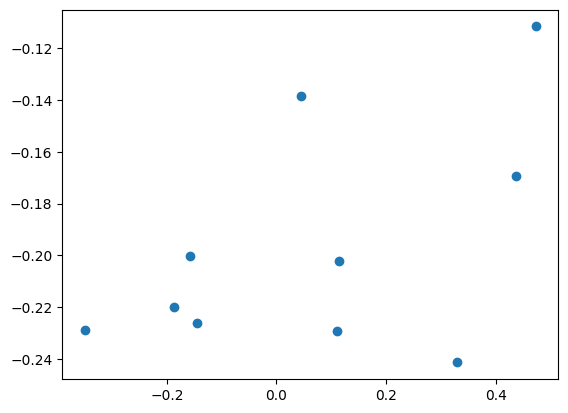

In [43]:
plt.scatter(cp_coefs, edss_coefs)

In [10]:
# data_to_sample = df_z.join(df_thomas_z).reset_index()
# inds = np.random.randint(0, len(data_to_sample), size=(300,))

# rng = np.random.default_rng()
# inds = rng.choice(len(data_to_sample), 200)
# model_data = data_to_sample.loc[inds, :].set_index("subid")

model_data = df_z.join(df_thomas_norm_z)
model_data = model_data[model_data['dz_type5'].isin(["RMS", "PMS"])]
covariates = "age + Female + tiv"

pvals = {}
coefs = {}
stderrs = {}
llci = {}
ulci = {}
ci_str = {}
r2 = {}

outcome = "EDSS_sqrt"

structs = thalamic_nuclei
all_results = {}
for x in structs:
    col = hips_thomas_ref[x]
    check_variable = col
    formula = f"{outcome} ~ {col} + dzdur + {covariates}"
    res = sm.OLS.from_formula(formula, data=model_data).fit()
    all_results[col] = res
    pvals[col] = res.pvalues[check_variable]
    coefs[col] = res.params[check_variable]
    stderrs[col] = res.HC0_se[check_variable]
    ci = res.conf_int()
    llci[col] = ci.loc[check_variable, 0]
    ulci[col] = ci.loc[check_variable, 1]
    ci_str[col] = f"[{llci[col]:.6f}, {ulci[col]:.6f}]"
    r2[col] = res.rsquared_adj



regression_results = pd.DataFrame({"coef": coefs, "stderr": stderrs, "llci": llci, "ulci": ulci, "pvals": pvals, "ci": ci_str})
regression_results['p_fdr'] = stats.false_discovery_control(
    regression_results['pvals'], method='bh'
)
regression_results['R2'] = r2
regression_results.sort_values(by="coef", inplace=True)
# regression_results.to_excel(fig_path / "thalamic_nuclei_normed.xlsx")
main_coefs = np.array([coefs[hips_thomas_ref[x]] for x in structs])

regression_results

,coef,stderr,llci,ulci,pvals,ci,p_fdr,R2
AV_2,-0.154345,0.047194,-0.241740,-0.066950,5.692932e-04,"[-0.241740, -0.066950]",0.001898,0.262944
Pul_8,-0.133996,0.039792,-0.215067,-0.052925,1.248652e-03,"[-0.215067, -0.052925]",0.002683,0.260535
LGN_9,-0.131651,0.036268,-0.211819,-0.051482,1.341330e-03,"[-0.211819, -0.051482]",0.002683,0.260316
VPL_7,-0.027785,0.040074,-0.109674,0.054104,5.052270e-01,"[-0.109674, 0.054104]",0.561363,0.243833
MD_Pf_12,0.005242,0.039789,-0.074434,0.084918,8.971808e-01,"[-0.074434, 0.084918]",0.897181,0.243109
VLP_6,0.052063,0.042552,-0.033403,0.137530,2.318691e-01,"[-0.033403, 0.137530]",0.289836,0.245500
CM_11,0.095185,0.044543,0.011275,0.179095,2.628673e-02,"[0.011275, 0.179095]",0.043811,0.251404
MGN_10,0.095726,0.045784,0.006696,0.184756,3.514707e-02,"[0.006696, 0.184756]",0.050210,0.250567
VLa_5,0.166856,0.041158,0.084104,0.249607,8.624561e-05,"[0.084104, 0.249607]",0.000431,0.268768
VA_4,0.218348,0.038483,0.136894,0.299802,2.146383e-07,"[0.136894, 0.299802]",0.000002,0.287330


In [36]:
model_data = df_z.join([df_thomas])
model_data = model_data[model_data['dz_type2'] == "MS"]

for struct in hips_thomas_ref[thalamic_nuclei]:
    denom = list(set(hips_thomas_ref[thalamic_nuclei]) - set(struct))
    model_data[f'LR{struct}'] = log_ratio(model_data[struct].T, model_data[denom].T).T
    
covariates = "age + Female + tiv"
structs = thalamic_nuclei
structsLR = [f"LR{struct}" for struct in hips_thomas_ref[thalamic_nuclei]] 

pvals = {}
coefs = {}
stderrs = {}
llci = {}
ulci = {}
ci_str = {}
r2 = {}

outcome = "EDSS_sqrt"

all_results = {}
for x in structsLR:
    col = x
    formula = f"{outcome} ~ {col} + {covariates}"
    res = sm.OLS.from_formula(formula, data=model_data).fit()
    all_results[col] = res
    pvals[col] = res.pvalues[col]
    coefs[col] = res.params[col]
    stderrs[col] = res.HC0_se[col]
    ci = res.conf_int()
    llci[col] = ci.loc[col, 0]
    ulci[col] = ci.loc[col, 1]
    ci_str[col] = f"[{llci[col]:.6f}, {ulci[col]:.6f}]"
    r2[col] = res.rsquared_adj


regression_results = pd.DataFrame({"coef": coefs, "stderr": stderrs, "llci": llci, "ulci": ulci, "pvals": pvals, "ci": ci_str})
regression_results['p_fdr'] = stats.false_discovery_control(
    regression_results['pvals'], method='bh'
)
regression_results['R2'] = r2
regression_results.sort_values(by="coef", inplace=True)
# regression_results.to_excel(fig_path / "thalamic_nuclei_normed.xlsx")
main_coefs = np.array([coefs[x] for x in structsLR])

regression_results

/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not

,coef,stderr,llci,ulci,pvals,ci,p_fdr,R2
LRPul_8,-0.844868,0.312896,-1.461321,-0.228414,7.336723e-03,"[-1.461321, -0.228414]",1.048103e-02,0.224975
LRLGN_9,-0.548309,0.181941,-0.884182,-0.212436,1.431081e-03,"[-0.884182, -0.212436]",2.385135e-03,0.230114
LRAV_2,-0.431581,0.107683,-0.637382,-0.225779,4.488603e-05,"[-0.637382, -0.225779]",1.496201e-04,0.241194
LRVPL_7,-0.016697,0.391106,-0.748119,0.714725,9.642358e-01,"[-0.748119, 0.714725]",9.642358e-01,0.212428
LRMD_Pf_12,0.273513,0.419091,-0.576043,1.123070,5.272414e-01,"[-0.576043, 1.123070]",5.858238e-01,0.213128
LRVLP_6,0.969237,0.382037,0.150317,1.788157,2.046348e-02,"[0.150317, 1.788157]",2.557935e-02,0.221823
LRCM_11,1.084391,0.307606,0.484012,1.684770,4.265571e-04,"[0.484012, 1.684770]",8.531142e-04,0.233969
LRMGN_10,1.354242,0.383550,0.610345,2.098138,3.843856e-04,"[0.610345, 2.098138]",8.531142e-04,0.234302
LRVLa_5,1.358682,0.263917,0.819099,1.898265,1.059808e-06,"[0.819099, 1.898265]",5.299038e-06,0.253244
LRVA_4,1.816845,0.268781,1.253347,2.380343,5.733845e-10,"[1.253347, 2.380343]",5.733845e-09,0.277204


#### Control for whole thalamus volume

Correlate each of the thalamic nuclei to EDSS, including whole thalalmic volume as a covariate. None of the p values are significant, but we can still compare coefficients to see each nucleus's relative contribution to EDSS. Will bootstrap these regressions in the following cell to see if the rank is significant.  

In [25]:
model_data = df_z.join(df_thomas_z)
model_data['whole_thalamus'] = df_thomas_z['THALAMUS_1']
model_data = model_data[model_data['dz_type5'].isin(["RMS", "PMS"])]
covariates = "age + Female + tiv + whole_thalamus + periCSF"

pvals = {}
coefs = {}
thal_coefs = {}
stderrs = {}
llci = {}
ulci = {}
ci_str = {}
r2 = {}


outcome = "EDSS_sqrt"

structs = thalamic_nuclei
all_results = {}
for x in structs:
    col = hips_thomas_ref[x]
    formula = f"{outcome} ~ {col} + {covariates}"
    res = sm.OLS.from_formula(formula, data=model_data).fit()
    pvals[col] = res.pvalues[col]
    coefs[col] = res.params[col]
    thal_coefs[col] = res.params['whole_thalamus']
    stderrs[col] = res.HC0_se[col]
    ci = res.conf_int()
    llci[col] = ci.loc[col, 0]
    ulci[col] = ci.loc[col, 1]
    ci_str[col] = f"[{llci[col]:.6f}, {ulci[col]:.6f}]"
    r2[col] = res.rsquared_adj



regression_results = pd.DataFrame({"coef": coefs, "thal_coef": thal_coefs, "stderr": stderrs, "llci": llci, "ulci": ulci, "pvals": pvals, "ci": ci_str})
regression_results['p_fdr'] = stats.false_discovery_control(
    regression_results['pvals'], method='bh'
)
regression_results['R2'] = r2

main_coefs = np.array([coefs[hips_thomas_ref[x]] for x in structs])
regression_results.sort_values(by="coef", inplace=True)
# regression_results.to_excel(fig_path / "thalamic_nuclei-thalamus_control.xlsx")
regression_results

,coef,thal_coef,stderr,llci,ulci,pvals,ci,p_fdr,R2
LGN_9,-0.116818,-0.216408,0.053813,-0.236081,0.002445,0.054863,"[-0.236081, 0.002445]",0.476888,0.279776
AV_2,-0.105222,-0.239642,0.066955,-0.228960,0.018515,0.095378,"[-0.228960, 0.018515]",0.476888,0.278308
VPL_7,-0.093221,-0.233908,0.077038,-0.251768,0.065327,0.248490,"[-0.251768, 0.065327]",0.509344,0.275951
VLP_6,-0.074257,-0.249397,0.093022,-0.256776,0.108261,0.424379,"[-0.256776, 0.108261]",0.606255,0.274820
Pul_8,-0.038968,-0.271148,0.128553,-0.285396,0.207460,0.756115,"[-0.285396, 0.207460]",0.840128,0.273936
VLa_5,-0.026101,-0.296400,0.062674,-0.150397,0.098195,0.680025,"[-0.150397, 0.098195]",0.840128,0.274056
MGN_10,-0.009524,-0.302680,0.071498,-0.155587,0.136539,0.898090,"[-0.155587, 0.136539]",0.898090,0.273805
CM_11,0.074886,-0.360798,0.069076,-0.054152,0.203924,0.254672,"[-0.054152, 0.203924]",0.509344,0.275895
VA_4,0.095960,-0.363995,0.065677,-0.038926,0.230847,0.162765,"[-0.038926, 0.230847]",0.509344,0.276955
MD_Pf_12,0.102424,-0.410562,0.105695,-0.114801,0.319649,0.354604,"[-0.114801, 0.319649]",0.591007,0.275177


Bootstrap the regressions

In [29]:
model_data = df_z.join([df_thomas_z])
model_data = model_data[model_data['dz_type2'] == "MS"]

model_combined = sm.OLS.from_formula(
    """EDSS_sqrt ~ VLP_6 + age + Female + tiv + periCSF""",
    data=model_data
).fit()

print(model_combined.summary())

                            OLS Regression Results                            
Dep. Variable:              EDSS_sqrt   R-squared:                       0.272
Model:                            OLS   Adj. R-squared:                  0.264
Method:                 Least Squares   F-statistic:                     33.37
Date:                Thu, 30 Oct 2025   Prob (F-statistic):           6.11e-29
Time:                        02:31:33   Log-Likelihood:                -574.38
No. Observations:                 452   AIC:                             1161.
Df Residuals:                     446   BIC:                             1185.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0100      0.041     -0.244      0.8

In [23]:
df_z['THALAMUS_1']

KeyError: 'THALAMUS_1'

In [81]:
data_to_sample = df_z.join(df_thomas_z)
data_to_sample = data_to_sample[data_to_sample['dz_type5'].isin(["RMS", "PMS"])].reset_index()
data_to_sample.loc[data_to_sample['EDSS_sqrt'].isna(), 'EDSS_sqrt'] = model_data['EDSS_sqrt'].median()

covariates = "age + Female + tiv"

def get_zeros():
    return np.zeros((1000,))

coefs_boot1 = defaultdict(get_zeros)

outcome = "EDSS_sqrt"

for i in tqdm(range(1000)):
    inds = np.random.randint(0, data_to_sample.index.max(), len(data_to_sample))
    model_data = data_to_sample.loc[inds, :]
    for x in structs:
        col = hips_thomas_ref[x]
        formula = f"{outcome} ~ {col}*dzdur + {covariates}"
        res = sm.OLS.from_formula(formula, data=model_data).fit()
        coefs_boot1[col][i] = res.params[col]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [84]:
data_to_sample = df_z.join(df_thomas_z)
data_to_sample = data_to_sample[data_to_sample['dz_type5'].isin(["RMS", "PMS"])].reset_index()
data_to_sample.loc[data_to_sample['EDSS_sqrt'].isna(), 'EDSS_sqrt'] = model_data['EDSS_sqrt'].median()

covariates = "age + Female + tiv + THALAMUS_1"

def get_zeros():
    return np.zeros((1000,))

coefs_boot2 = defaultdict(get_zeros)

outcome = "EDSS_sqrt"

for i in tqdm(range(1000)):
    inds = np.random.randint(0, data_to_sample.index.max(), len(data_to_sample))
    model_data = data_to_sample.loc[inds, :]
    for x in structs:
        col = hips_thomas_ref[x]
        formula = f"{outcome} ~ {col}*dzdur + {covariates}"
        res = sm.OLS.from_formula(formula, data=model_data).fit()
        coefs_boot2[col][i] = res.params[col]

  0%|          | 0/1000 [00:00<?, ?it/s]

Get the mean and 95% CI of the bootstrapped coefficients for each nucleus

In [39]:
coefs_copy = coefs_boot2.copy()
llci = {}
ulci = {}
means = {}
for x in structs:
    col = hips_thomas_ref[x]
    coefs_copy[col] = np.sort(coefs_copy[col])
    llci[col] = coefs_copy[col][25]
    ulci[col] = coefs_copy[col][975]
    means[col] = np.mean(coefs_copy[col])
    print(f"{means[col]:.4f} [{llci[col]:2.2f}, {ulci[col]:2.2f}]")

coefs_bootmean = np.array([means[hips_thomas_ref[x]] for x in structs])
np.corrcoef(main_coefs, coefs_bootmean)[0,1]

-0.1090 [-0.25, 0.02]
0.1029 [-0.02, 0.23]
-0.0241 [-0.15, 0.10]
-0.0599 [-0.23, 0.12]
-0.0667 [-0.22, 0.09]
-0.0583 [-0.33, 0.19]
-0.1281 [-0.23, -0.02]
-0.0202 [-0.17, 0.12]
0.0745 [-0.05, 0.21]
0.0838 [-0.12, 0.29]


0.9819684379090603

Correlate the coefficients of the nuclei for each boostrapped sample to the main regression to see if the relative strengths of the nuclei's coefficients are consistent across resamples

In [101]:
coefs_boot_arr = np.zeros((len(structs), 1000))
for i, x in enumerate(structs):
    col = hips_thomas_ref[x]
    coefs_boot_arr[i, :] = coefs_boot2[col]

corr_coefs = np.zeros((1000,))
kendal_taus = np.zeros((1000,))
for i in range(1000):
    corr_coefs[i] = np.corrcoef(coefs_boot_arr[:,i], main_coefs)[0,1]
    kendal_taus[i] = stats.kendalltau(coefs_boot_arr[:,i], main_coefs)[0]
mean_corrcoef = np.mean(corr_coefs)
mean_tau = np.mean(kendal_taus)
corr_coefs = np.sort(corr_coefs)
kendal_taus = np.sort(kendal_taus)
print(f"{mean_corrcoef:.2f} [{corr_coefs[25]:.2f}, {corr_coefs[975]:.2f}]")
print(f"{mean_tau:.2f} [{kendal_taus[25]:.2f}, {kendal_taus[975]:.2f}]")

0.56 [-0.02, 0.90]
0.44 [0.02, 0.73]


In [102]:
win_counts = np.zeros((coefs_boot_arr.shape[0],))
for i in range(1000):
    win_counts[coefs_boot_arr[:,i].argmin()] += 1

win_count_df = pd.Series(win_counts/1000, index=hips_thomas_ref[thalamic_nuclei])
win_count_df.sort_values(ascending=False)

struct
AV_2        0.301
Pul_8       0.265
LGN_9       0.180
VLP_6       0.113
VPL_7       0.108
MGN_10      0.017
VLa_5       0.012
MD_Pf_12    0.004
VA_4        0.000
CM_11       0.000
dtype: float64

In [44]:
coefs_boot_arr = np.zeros((len(structs), 1000))
for i, x in enumerate(structs):
    col = hips_thomas_ref[x]
    coefs_boot_arr[i, :] = coefs_boot1[col]
win_counts = np.zeros((coefs_boot_arr.shape[0],))
for i in range(1000):
    win_counts[coefs_boot_arr[:,i].argmin()] += 1

win_count_df = pd.Series(win_counts/1000, index=hips_thomas_ref[thalamic_nuclei])
win_count_df.sort_values(ascending=False)

struct
VLP_6       0.338
AV_2        0.183
Pul_8       0.165
VPL_7       0.127
LGN_9       0.113
MGN_10      0.042
VLa_5       0.022
MD_Pf_12    0.009
CM_11       0.001
VA_4        0.000
dtype: float64

In [6]:
model_data = df_z.join([df_thomas2_norm_z])
model_data = model_data[model_data.dz_type2 == "MS"]

covariates = "age + Female + tiv + dzdur + t2lv"

pvals = {}
coefs = {}
stderrs = {}
llci = {}
ulci = {}
ci_str = {}

for col in grouped_nuclei:
    formula = f"EDSS_sqrt ~ {col} + {covariates}"
    res = sm.OLS.from_formula(formula, data=model_data).fit()
    pvals[col] = res.pvalues[col]
    coefs[col] = res.params[col]
    stderrs[col] = res.HC0_se[col]
    ci = res.conf_int()
    llci[col] = ci.loc[col, 0]
    ulci[col] = ci.loc[col, 1]
    ci_str[col] = f"[{llci[col]:.6f}, {ulci[col]:.6f}]"

regression_results = pd.DataFrame({"coef": coefs, "stderr": stderrs, "llci": llci, "ulci": ulci, "pvals": pvals, "ci": ci_str})
regression_results['p_fdr'] = stats.false_discovery_control(
    regression_results['pvals'], method='bh'
)

regression_results.sort_values(by="coef")

,coef,stderr,llci,ulci,pvals,ci,p_fdr
anterior,-0.142081,0.047529,-0.230958,-0.053203,0.001791,"[-0.230958, -0.053203]",0.006452
posterior,-0.128004,0.041423,-0.212953,-0.043055,0.003226,"[-0.212953, -0.043055]",0.006452
medial,0.033585,0.038978,-0.045280,0.112450,0.403076,"[-0.045280, 0.112450]",0.403076
ventral,0.115369,0.043658,0.022509,0.208229,0.015007,"[0.022509, 0.208229]",0.020009


In [46]:
model_data = df_z.join([df_thomas2_norm_z])
model_data = model_data[model_data.dz_type2 == "MS"]

covariates = "age + Female + tiv"

for col in grouped_nuclei:
    formula = f"{col} ~ choroid_volume + {covariates}"
    res = sm.OLS.from_formula(formula, data=model_data).fit()
    print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               anterior   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.143
Method:                 Least Squares   F-statistic:                     20.45
Date:                Sun, 17 Aug 2025   Prob (F-statistic):           1.57e-15
Time:                        20:55:47   Log-Likelihood:                -616.22
No. Observations:                 468   AIC:                             1242.
Df Residuals:                     463   BIC:                             1263.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.0636      0.042     -1.

In [31]:
model_data = df_z.copy()
struct_names = []
for col in df_thomas2.columns[~df_thomas2.columns.isin(["THALAMUS_1"])]:
    model_data[f'{col}_left'] = df_thomas2_norm_left_z[col]
    struct_names.append(f'{col}_left')
    model_data[f'{col}_right'] = df_thomas2_norm_right_z[col]
    struct_names.append(f'{col}_right')
model_data['whole_thalamus'] = df_thomas_z['THALAMUS_1']

covariates = "age + Female + tiv"

pvals = {}
coefs = {}
stderrs = {}
llci = {}
ulci = {}
ci_str = {}

for col in struct_names:
    formula = f"EDSS_sqrt ~ {col}*dzdur + {covariates}"
    res = sm.OLS.from_formula(formula, data=model_data).fit()
    pvals[col] = res.pvalues[col]
    coefs[col] = res.params[col]
    stderrs[col] = res.HC0_se[col]
    ci = res.conf_int()
    llci[col] = ci.loc[col, 0]
    ulci[col] = ci.loc[col, 1]
    ci_str[col] = f"[{llci[col]:.6f}, {ulci[col]:.6f}]"

regression_results = pd.DataFrame({"coef": coefs, "stderr": stderrs, "llci": llci, "ulci": ulci, "pvals": pvals, "ci": ci_str})
regression_results['p_fdr'] = stats.false_discovery_control(
    regression_results['pvals'], method='bh'
)

regression_results.sort_values(by="coef")

,coef,stderr,llci,ulci,pvals,ci,p_fdr
anterior_left,-0.162114,0.046174,-0.247317,-0.076911,0.000208,"[-0.247317, -0.076911]",0.001038
anterior_right,-0.162114,0.046174,-0.247317,-0.076911,0.000208,"[-0.247317, -0.076911]",0.001038
posterior_right,-0.128666,0.038341,-0.207566,-0.049766,0.001445,"[-0.207566, -0.049766]",0.003613
posterior_left,-0.128666,0.038341,-0.207566,-0.049766,0.001445,"[-0.207566, -0.049766]",0.003613
medial_left,0.000976,0.037770,-0.078336,0.080288,0.980714,"[-0.078336, 0.080288]",0.980714
medial_right,0.000976,0.037770,-0.078336,0.080288,0.980714,"[-0.078336, 0.080288]",0.980714
intralaminar_right,0.083412,0.043875,-0.000540,0.167364,0.051487,"[-0.000540, 0.167364]",0.064358
intralaminar_left,0.083412,0.043875,-0.000540,0.167364,0.051487,"[-0.000540, 0.167364]",0.064358
ventral_left,0.120768,0.039946,0.036056,0.205479,0.005298,"[0.036056, 0.205479]",0.008829
ventral_right,0.120768,0.039946,0.036056,0.205479,0.005298,"[0.036056, 0.205479]",0.008829


In [16]:
model_data = df_z[['EDSS_sqrt', 'age']].copy()
struct_names = []
for col in df_thomas2.columns:
    model_data[f'{col}_left'] = df_thomas2_left_z[col]
    struct_names.append(f'{col}_left')
    model_data[f'{col}_right'] = df_thomas2_right_z[col]
    struct_names.append(f'{col}_right')
model_data['whole_thalamus'] = df_thomas_z['THALAMUS_1']
struct_names

['anterior_left',
 'anterior_right',
 'ventral_left',
 'ventral_right',
 'intralaminar_left',
 'intralaminar_right',
 'medial_left',
 'medial_right',
 'posterior_left',
 'posterior_right',
 'THALAMUS_1_left',
 'THALAMUS_1_right']

In [89]:
data_to_sample = df_z.join(df_thomas2_z)
data_to_sample = data_to_sample[data_to_sample['dz_type5'].isin(["RMS", "PMS"])].reset_index()
data_to_sample.loc[data_to_sample['EDSS_sqrt'].isna(), 'EDSS_sqrt'] = model_data['EDSS_sqrt'].median()

covariates = "age + Female + tiv + THALAMUS_1"
structs = df_thomas2.columns[~df_thomas2.columns.isin(["THALAMUS_1"])]

def get_zeros():
    return np.zeros((1000,))

coefs_boot3 = defaultdict(get_zeros)

outcome = "EDSS_sqrt"

for i in tqdm(range(1000)):
    inds = np.random.randint(0, data_to_sample.index.max(), len(data_to_sample))
    model_data = data_to_sample.loc[inds, :]
    for col in structs:
        formula = f"{outcome} ~ {col}*dzdur + {covariates}"
        res = sm.OLS.from_formula(formula, data=model_data).fit()
        coefs_boot3[col][i] = res.params[col]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [90]:
coefs_boot_arr = np.zeros((len(structs), 1000))
for i, col in enumerate(structs):
    coefs_boot_arr[i, :] = coefs_boot3[col]
win_counts = np.zeros((coefs_boot_arr.shape[0],))
for i in range(1000):
    win_counts[coefs_boot_arr[:,i].argmin()] += 1

win_count_df = pd.Series(win_counts/1000, index=structs)
win_count_df.sort_values(ascending=False)

posterior       0.454
anterior        0.395
ventral         0.143
intralaminar    0.004
medial          0.004
dtype: float64

In [117]:
model_data = df_z.join(df_thomas_z)

covariates = "age + Female + tiv"

pvals = {}
coefs = {}
stderrs = {}
llci = {}
ulci = {}
ci_str = {}

for x in thalamic_nuclei:
    col = hips_thomas_ref[x]
    res = sm.OLS.from_formula(f"{col} ~ THALAMUS_1 + tiv", data=model_data).fit()
    model_data[f"{col}_resid"] = res.resid

    col2 = f"{col}_resid"
    formula = f"EDSS_sqrt ~ {col2}*dzdur + {covariates}"
    res = sm.OLS.from_formula(formula, data=model_data).fit()
    pvals[col] = res.pvalues[col2]
    coefs[col] = res.params[col2]
    stderrs[col] = res.HC0_se[col2]
    ci = res.conf_int()
    llci[col] = ci.loc[col2, 0]
    ulci[col] = ci.loc[col2, 1]
    ci_str[col] = f"[{llci[col]:.6f}, {ulci[col]:.6f}]"

regression_results = pd.DataFrame({"coef": coefs, "stderr": stderrs, "llci": llci, "ulci": ulci, "pvals": pvals, "ci": ci_str})
regression_results['p_fdr'] = stats.false_discovery_control(
    regression_results['pvals'], method='bh'
)

regression_results.sort_values(by="coef")

,coef,stderr,llci,ulci,pvals,ci,p_fdr
LGN_9,-0.149686,0.051829,-0.264497,-0.034874,0.010720,"[-0.264497, -0.034874]",0.107202
VPL_7,-0.109161,0.077652,-0.265438,0.047115,0.170535,"[-0.265438, 0.047115]",0.426338
VLP_6,-0.106625,0.092477,-0.286748,0.073498,0.245336,"[-0.286748, 0.073498]",0.490673
AV_2,-0.088672,0.070059,-0.210556,0.033211,0.153502,"[-0.210556, 0.033211]",0.426338
Pul_8,-0.029199,0.124842,-0.269485,0.211087,0.811376,"[-0.269485, 0.211087]",0.997240
MGN_10,-0.007467,0.073632,-0.150230,0.135296,0.918183,"[-0.150230, 0.135296]",0.997240
VLa_5,0.000216,0.064464,-0.122552,0.122984,0.997240,"[-0.122552, 0.122984]",0.997240
CM_11,0.060011,0.067940,-0.067810,0.187832,0.356714,"[-0.067810, 0.187832]",0.514482
MD_Pf_12,0.100432,0.104229,-0.115016,0.315881,0.360137,"[-0.115016, 0.315881]",0.514482
VA_4,0.124176,0.062814,-0.004679,0.253031,0.058882,"[-0.004679, 0.253031]",0.294409


In [124]:
model_data = df_z.join([df_thomas2_z])
model_data = model_data[model_data.dz_type2 == "MS"]

covariates = "age + Female + tiv + THALAMUS_1"

pvals = {}
coefs = {}
stderrs = {}
llci = {}
ulci = {}
ci_str = {}

for col in df_thomas2:
    formula = f"EDSS_sqrt ~ {col}*dzdur + {covariates}"
    res = sm.OLS.from_formula(formula, data=model_data).fit()
    pvals[col] = res.pvalues[col]
    coefs[col] = res.params[col]
    stderrs[col] = res.HC0_se[col]
    ci = res.conf_int()
    llci[col] = ci.loc[col, 0]
    ulci[col] = ci.loc[col, 1]
    ci_str[col] = f"[{llci[col]:.6f}, {ulci[col]:.6f}]"

regression_results = pd.DataFrame({"coef": coefs, "stderr": stderrs, "llci": llci, "ulci": ulci, "pvals": pvals, "ci": ci_str})
regression_results['p_fdr'] = stats.false_discovery_control(
    regression_results['pvals'], method='bh'
)

regression_results.sort_values(by="coef")

,coef,stderr,llci,ulci,pvals,ci,p_fdr
THALAMUS_1,-0.238654,0.045351,-0.334926,-0.142382,0.000002,"[-0.334926, -0.142382]",0.000009
anterior,-0.132947,0.069969,-0.257915,-0.007978,0.037114,"[-0.257915, -0.007978]",0.111343
posterior,-0.130666,0.128086,-0.381456,0.120125,0.306410,"[-0.381456, 0.120125]",0.459615
ventral,-0.030548,0.104296,-0.242056,0.180960,0.776657,"[-0.242056, 0.180960]",0.776657
intralaminar,0.052855,0.069251,-0.074872,0.180583,0.416498,"[-0.074872, 0.180583]",0.499797
medial,0.126086,0.102518,-0.087665,0.339838,0.246961,"[-0.087665, 0.339838]",0.459615


In [15]:
model_data = df_z.join([df_thomas2_z])
model_data = model_data[model_data.dz_type2 == "MS"]

covariates = "age + Female + tiv + THALAMUS_1"

pvals = {}
coefs = {}
stderrs = {}
llci = {}
ulci = {}
ci_str = {}

for col in df_thomas2:
    formula = f"choroid_volume ~ {col} + {covariates}"
    res = sm.OLS.from_formula(formula, data=model_data).fit()
    pvals[col] = res.pvalues[col]
    coefs[col] = res.params[col]
    stderrs[col] = res.HC0_se[col]
    ci = res.conf_int()
    llci[col] = ci.loc[col, 0]
    ulci[col] = ci.loc[col, 1]
    ci_str[col] = f"[{llci[col]:.6f}, {ulci[col]:.6f}]"

regression_results = pd.DataFrame({"coef": coefs, "stderr": stderrs, "llci": llci, "ulci": ulci, "pvals": pvals, "ci": ci_str})
regression_results['p_fdr'] = stats.false_discovery_control(
    regression_results['pvals'], method='bh'
)

regression_results.sort_values(by="coef")

,coef,stderr,llci,ulci,pvals,ci,p_fdr
THALAMUS_1,-0.471241,0.047756,-0.557449,-0.385033,3.496056e-24,"[-0.557449, -0.385033]",2.097633e-23
medial,-0.326169,0.103968,-0.522535,-0.129804,1.179600e-03,"[-0.522535, -0.129804]",2.359199e-03
posterior,-0.295484,0.118422,-0.527846,-0.063121,1.280286e-02,"[-0.527846, -0.063121]",1.536344e-02
intralaminar,-0.174645,0.065383,-0.292919,-0.056371,3.888490e-03,"[-0.292919, -0.056371]",5.832734e-03
anterior,0.055964,0.064762,-0.058611,0.170539,3.376318e-01,"[-0.058611, 0.170539]",3.376318e-01
ventral,0.597348,0.098615,0.408056,0.786639,1.243761e-09,"[0.408056, 0.786639]",3.731284e-09


#### Compositional Regressions

In [29]:
model_data = df.join([df_thomas])
model_data = model_data[model_data.dz_type2 == "MS"]

covariates = "age + Female + tiv"

num = ['Pul_8', 'VPL_7', 'MGN_10']
denom = set(hips_thomas_ref[thalamic_nuclei]) - set(num)
model_data['balance'] = balance(model_data[num].T, model_data[list(denom)].T)

formula = f"EDSS_sqrt ~ balance + {covariates}"
res = sm.OLS.from_formula(formula, model_data).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              EDSS_sqrt   R-squared:                       0.219
Model:                            OLS   Adj. R-squared:                  0.212
Method:                 Least Squares   F-statistic:                     31.48
Date:                Sat, 16 Aug 2025   Prob (F-statistic):           4.00e-23
Time:                        17:05:01   Log-Likelihood:                -336.33
No. Observations:                 453   AIC:                             682.7
Df Residuals:                     448   BIC:                             703.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.3281      0.409      3.245      0.0

/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


### Deep Grey Structures

In [136]:
model_data = df_z.join(df_thomas_z)
model_data = model_data[model_data['dz_type5'].isin(["RMS", "PMS"])]
covariates = "age + Female + tiv"

pvals = {}
coefs = {}
stderrs = {}
llci = {}
ulci = {}

outcome = "EDSS_sqrt"
structs = hips_thomas_ref.index[~hips_thomas_ref.index.isin(thalamic_nuclei)]

all_results = {}
for x in structs:
    col = hips_thomas_ref[x]
    formula = f"{outcome} ~ {col} + {covariates}"
    res = sm.OLS.from_formula(formula, data=model_data).fit()
    pvals[col] = res.pvalues[col]
    coefs[col] = res.params[col]
    stderrs[col] = res.HC0_se[col]
    ci = res.conf_int()
    llci[col] = ci.loc[col, 0]
    ulci[col] = ci.loc[col, 1]


regression_results = pd.DataFrame({"coef": coefs, "stderr": stderrs, "llci": llci, "ulci": ulci, "pvals": pvals})
regression_results['p_fdr'] = stats.false_discovery_control(
    regression_results['pvals'], method='bh'
)
regression_results.sort_values(by="coef", inplace=True)
regression_results.to_csv(fig_path / "deep_grey_regressions.csv")
regression_results

,coef,stderr,llci,ulci,pvals,p_fdr
THALAMUS_1,-0.294878,0.045745,-0.388220,-0.201536,1.220738e-09,1.464886e-08
Cla_28,-0.215097,0.049181,-0.313742,-0.116452,2.235316e-05,1.341189e-04
Acc_26,-0.177858,0.048999,-0.280341,-0.075376,7.065838e-04,2.826335e-03
RN_32,-0.148705,0.054090,-0.258899,-0.038512,8.282670e-03,1.987841e-02
Hb_13,-0.134733,0.043543,-0.219743,-0.049723,1.959034e-03,5.877101e-03
Cau_27,-0.133372,0.054594,-0.234685,-0.032058,9.991938e-03,1.998388e-02
Amy_34,-0.111904,0.045568,-0.200122,-0.023686,1.302889e-02,2.233524e-02
Put_31,-0.084238,0.059147,-0.192744,0.024269,1.277856e-01,1.916784e-01
GP_33,-0.073634,0.050006,-0.177461,0.030194,1.640826e-01,1.968991e-01
GPe_29,-0.073625,0.048188,-0.176024,0.028774,1.583391e-01,1.968991e-01


In [210]:
vif_data = df_thomas_z[hips_thomas_ref[thalamic_nuclei + [1]]]
vif = pd.DataFrame()
vif['struct'] = vif_data.columns
vif.set_index("struct", inplace=True)
vif['VIF'] = [variance_inflation_factor(vif_data.values, i, )
                          for i in range(len(vif_data.columns))]

In [225]:
model_data = df_z.join(df_thomas2_z)
model_data = model_data[model_data['dz_type5'].isin(["RMS", "PMS"])]
formula = f"EDSS_sqrt ~ age + Female + tiv + {" + ".join(df_thomas2_z.columns[~df_thomas2_z.columns.isin(["THALAMUS_1"])])}"
res = sm.OLS.from_formula(formula, data=model_data).fit()
print(res.summary())


                            OLS Regression Results                            
Dep. Variable:              EDSS_sqrt   R-squared:                       0.289
Model:                            OLS   Adj. R-squared:                  0.277
Method:                 Least Squares   F-statistic:                     22.61
Date:                Thu, 05 Jun 2025   Prob (F-statistic):           5.27e-29
Time:                        20:05:35   Log-Likelihood:                -569.77
No. Observations:                 453   AIC:                             1158.
Df Residuals:                     444   BIC:                             1195.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.0257      0.041     -0.631   

---

### Elastic Net Trials

In [46]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
import numpy as np

In [50]:
model_data = df_z.join(df_thomas_z)
model_data = model_data[model_data['dz_type5'].isin(["RMS", "PMS"])]
model_data = model_data[~model_data['EDSS_sqrt'].isna()]

structs = hips_thomas_ref[thalamic_nuclei]


X = model_data[structs]
y = model_data['EDSS_sqrt']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Lasso Regression model with a specific alpha (regularization strength)
alpha = 0.1  # Adjust alpha as needed
lasso = Lasso(alpha=alpha)

# Train the model
lasso.fit(X_train, y_train)

# Make predictions on the test set
y_pred = lasso.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Print the coefficients (note that some may be zero)
print("Coefficients:", lasso.coef_)

Mean Squared Error: 1.0688643148091397
Coefficients: [-0.16628181 -0.         -0.         -0.         -0.         -0.02281968
 -0.02927025 -0.15345964 -0.         -0.        ]


In [51]:
check = pd.DataFrame({"coef": lasso.coef_}, index=X.columns)
check['abs'] = check['coef'].abs()
check = check.sort_values(by="abs", ascending=False)
check

,coef,abs
AV_2,-0.166282,0.166282
MGN_10,-0.153460,0.153460
LGN_9,-0.029270,0.029270
Pul_8,-0.022820,0.022820
VA_4,-0.000000,0.000000
VLa_5,-0.000000,0.000000
VLP_6,-0.000000,0.000000
VPL_7,-0.000000,0.000000
CM_11,-0.000000,0.000000
MD_Pf_12,-0.000000,0.000000


In [49]:
from sklearn.linear_model import ElasticNetCV


regr = ElasticNetCV(cv=10, random_state=0)
regr.fit(X_train, y_train)
print(regr.alpha_)
print(regr.intercept_)
y_pred = regr.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(mse)

check = pd.DataFrame({"coef": regr.coef_}, index=X.columns)
check['abs'] = check['coef'].abs()
check = check.sort_values(by="abs", ascending=False)
check

0.04268818040991856
-0.005121767360380086
1.042679507226447


,coef,abs
AV_2,-0.203274,0.203274
MGN_10,-0.167571,0.167571
LGN_9,-0.058592,0.058592
Pul_8,-0.035116,0.035116
VLa_5,-0.013014,0.013014
VA_4,0.000000,0.000000
VLP_6,-0.000000,0.000000
VPL_7,0.000000,0.000000
CM_11,-0.000000,0.000000
MD_Pf_12,-0.000000,0.000000


In [245]:
formula = "EDSS_sqrt ~ age + Female + tiv + AV_2 + MGN_10"
res = sm.OLS.from_formula(formula, data=model_data).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              EDSS_sqrt   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.267
Method:                 Least Squares   F-statistic:                     33.94
Date:                Thu, 05 Jun 2025   Prob (F-statistic):           2.15e-29
Time:                        20:52:20   Log-Likelihood:                -574.28
No. Observations:                 453   AIC:                             1161.
Df Residuals:                     447   BIC:                             1185.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0215      0.041     -0.524      0.6